## Author : Loka Akash Reddy
### LGM VIP - Data Science September-2021
### Task 3 : Music Recommendation
### Dataset : https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data
### Importing required Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import missingno as msno
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,mean_squared_error,accuracy_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,VotingClassifier,AdaBoostClassifier
import lightgbm as lgb
import datetime
import math

In [2]:
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve,roc_auc_score,classification_report,roc_curve
from tqdm import tqdm

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Importing dataset

In [4]:
train = reduce_mem_usage(pd.read_csv('train.csv'))
test = reduce_mem_usage(pd.read_csv('test.csv'))
sei = pd.read_csv('song_extra_info.csv')
members = pd.read_csv('members.csv',parse_dates=['registration_init_time','expiration_date'])
songs = pd.read_csv('songs.csv')

Memory usage of dataframe is 337.71 MB
Memory usage after optimization is: 82.41 MB
Decreased by 75.6%
Memory usage of dataframe is 117.04 MB
Memory usage after optimization is: 42.17 MB
Decreased by 64.0%


In [5]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [6]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [7]:
sei.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [8]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13


In [9]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [10]:
train.info()
print("\n")
test.info()
print("\n")
sei.info()
print("\n")
members.info()
print("\n")
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype   
---  ------              -----   
 0   msno                category
 1   song_id             category
 2   source_system_tab   category
 3   source_screen_name  category
 4   source_type         category
 5   target              int8    
dtypes: category(5), int8(1)
memory usage: 82.4 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 6 columns):
 #   Column              Dtype   
---  ------              -----   
 0   id                  int32   
 1   msno                category
 2   song_id             category
 3   source_system_tab   category
 4   source_screen_name  category
 5   source_type         category
dtypes: category(5), int32(1)
memory usage: 42.2 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295971 entries, 0 to 2295970
Data columns (total 3 columns):
 #   Column  

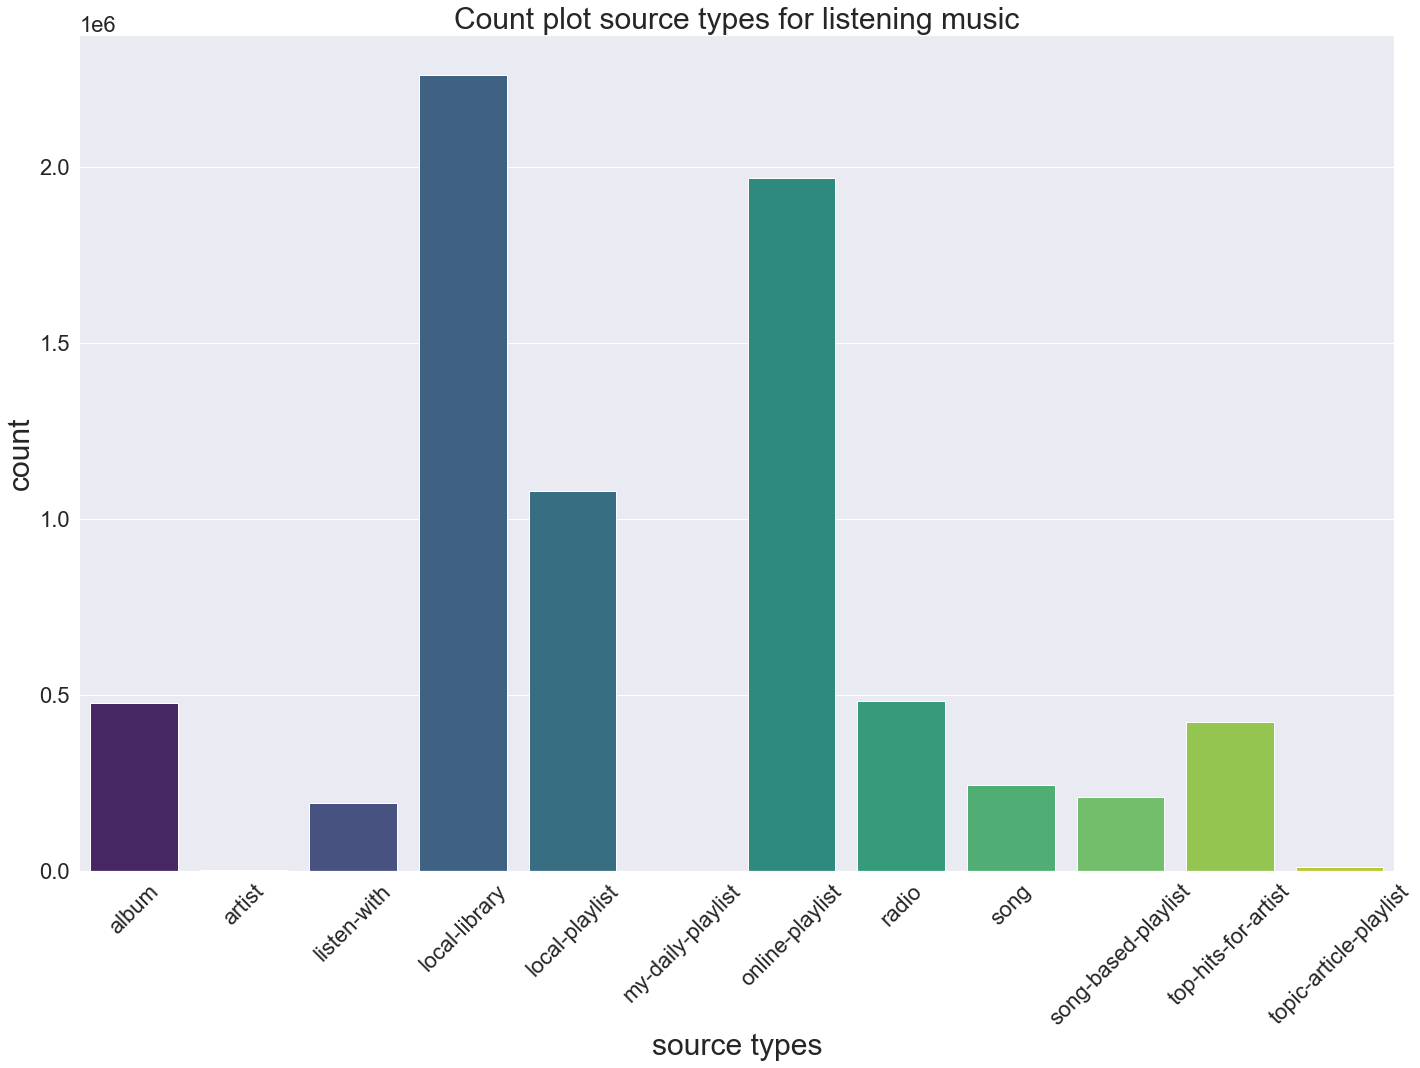

In [11]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(x='source_type', data=train, palette = 'viridis')
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot source types for listening music',fontsize=30)
plt.tight_layout()

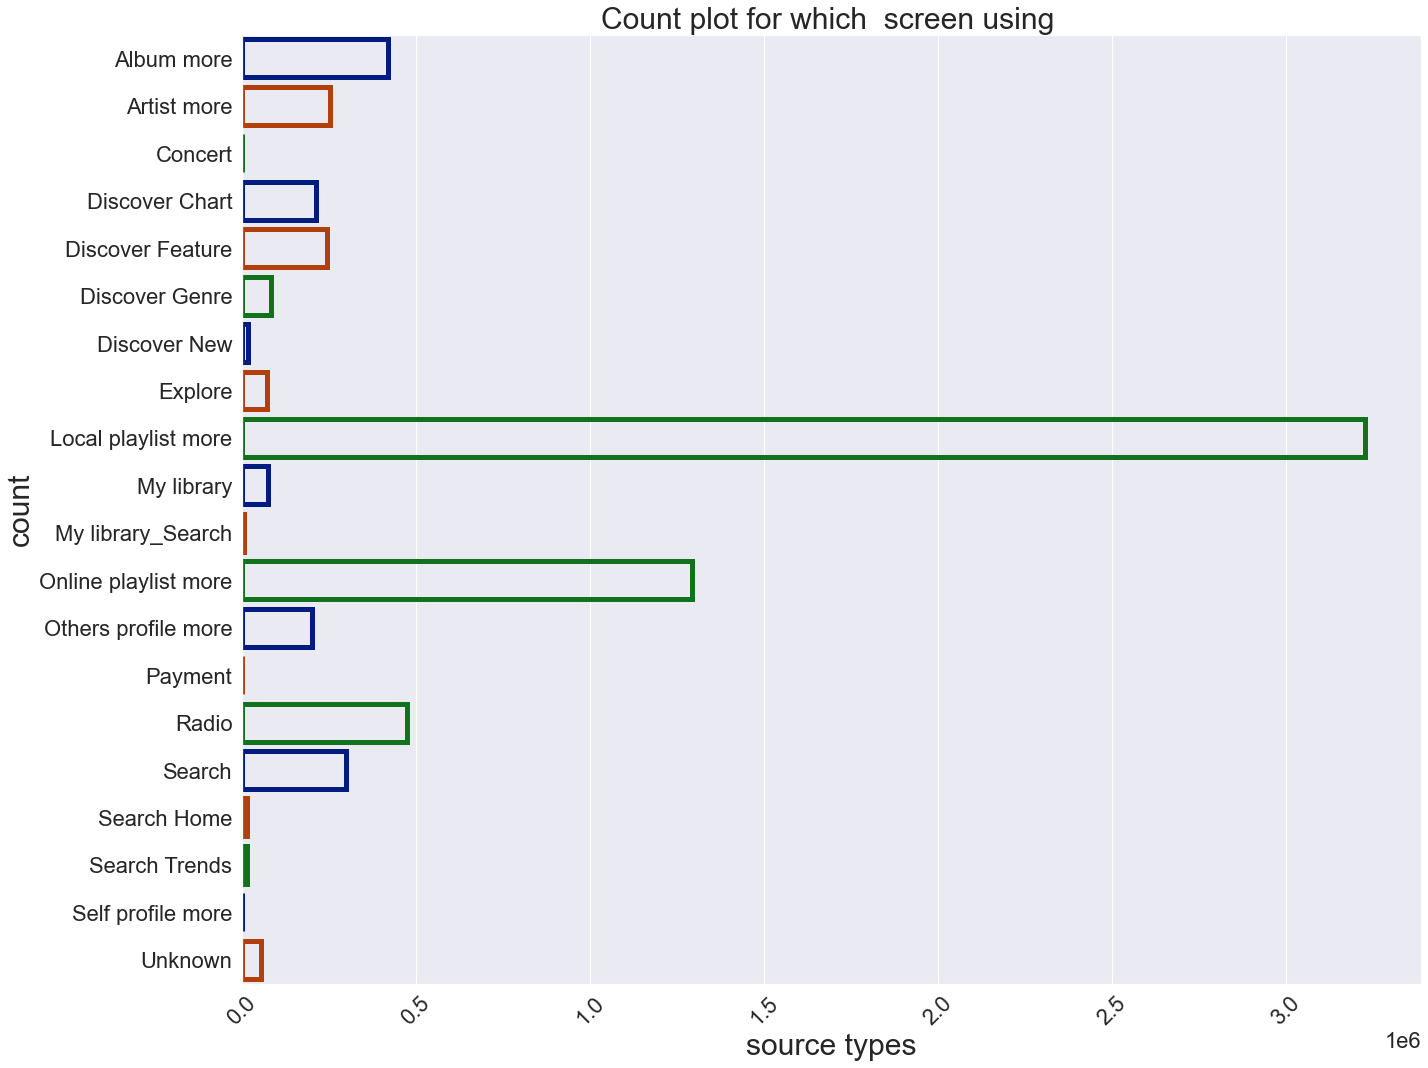

In [12]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(y='source_screen_name',data=train,facecolor=(0,0,0,0),linewidth=5,edgecolor=sns.color_palette('dark',3))
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot for which  screen using ',fontsize=30)
plt.tight_layout()

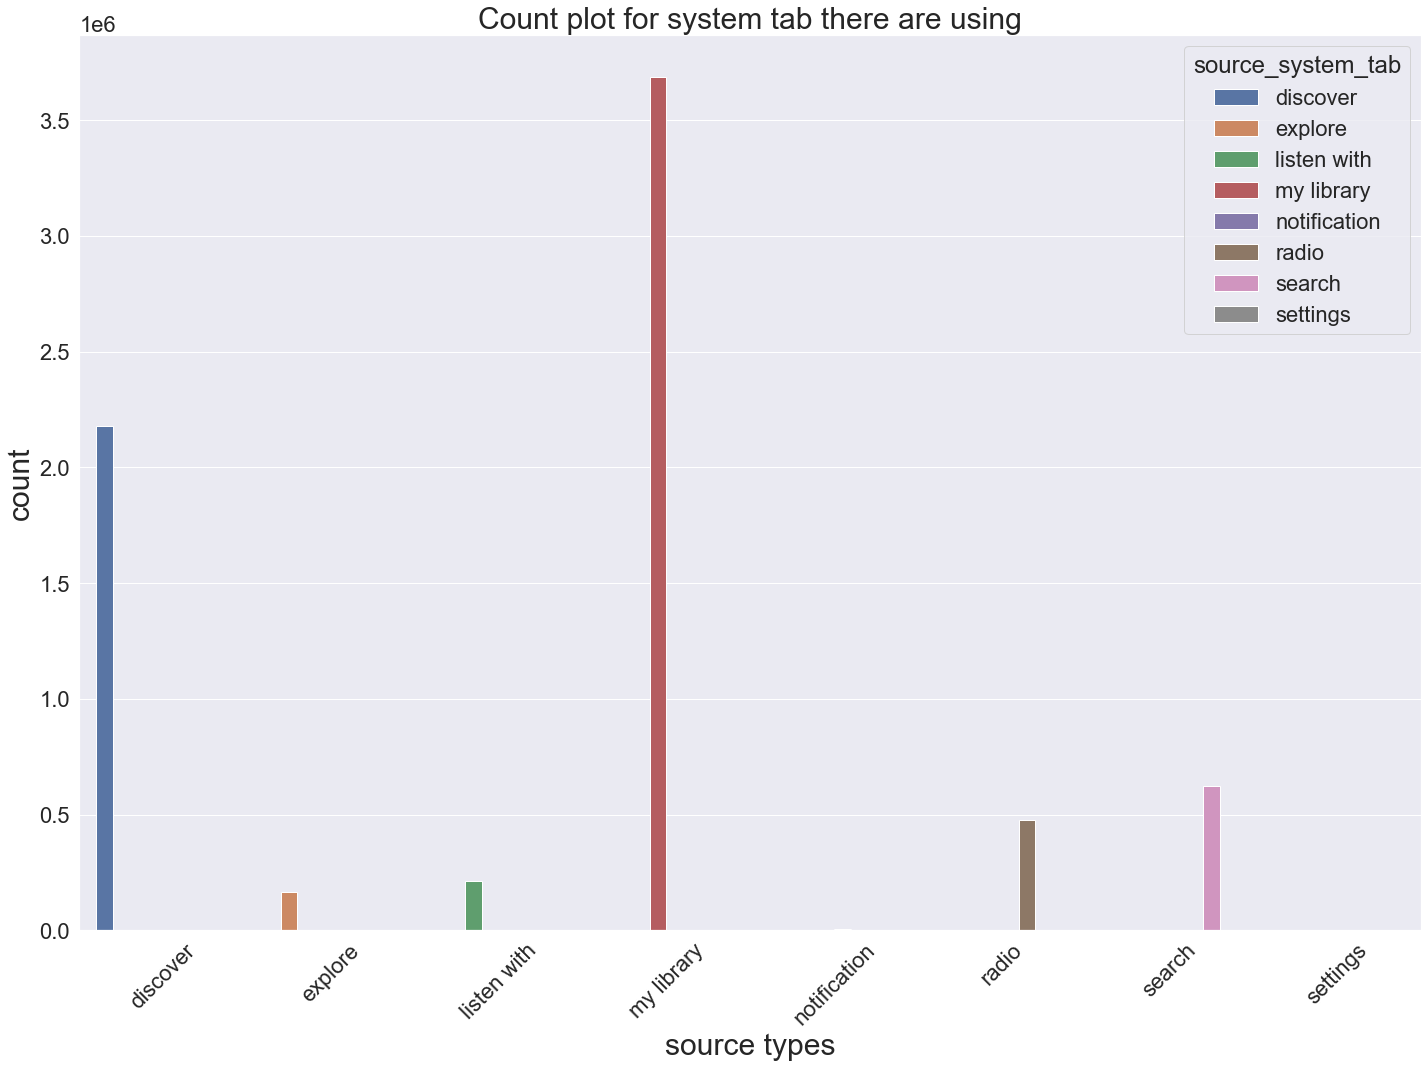

In [13]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(x='source_system_tab',hue='source_system_tab',data=train)
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot for system tab there are using',fontsize=30)
plt.tight_layout()

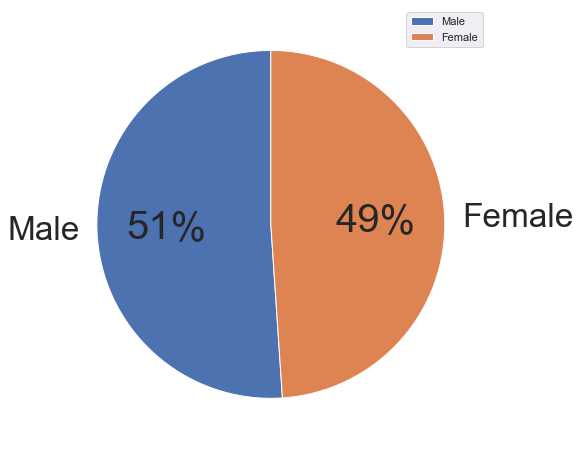

In [14]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 40.0
labels = ['Male','Female']
plt.figure(figsize = (8, 8))
sizes = pd.value_counts(members.gender)
patches, texts, autotexts = plt.pie(sizes, 
                                    labels=labels, autopct='%.0f%%',
                                    shadow=False, radius=1,startangle=90)
for t in texts:
    t.set_size('smaller')
plt.legend()
plt.show()

my library      3684730
discover        2179252
search           623286
radio            476701
listen with      212266
explore          167949
notification       6185
settings           2200
Name: source_system_tab, dtype: int64


<Figure size 1440x1440 with 0 Axes>

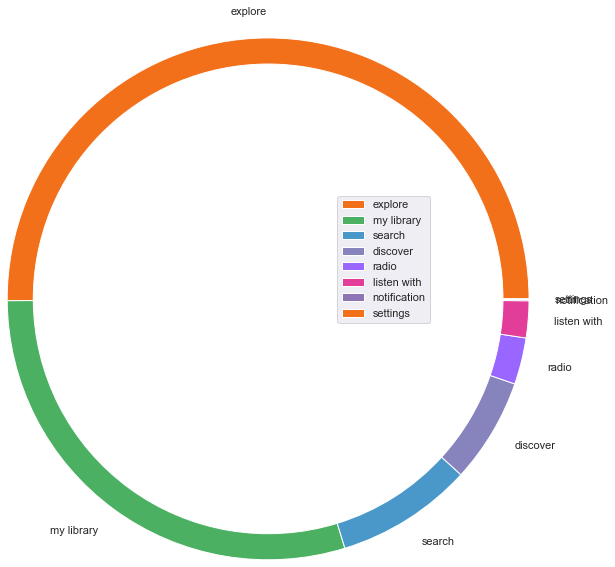

In [15]:
import matplotlib.pyplot as plt
mpl.rcParams['font.size'] = 40.0
plt.figure(figsize = (20, 20)) 
# Make data: I have 3 groups and 7 subgroups
group_names=['explore','my library','search','discover','radio','listen with','notification','settings']
group_size=pd.value_counts(train.source_system_tab)
print(group_size)
subgroup_names=['Male','Female']
subgroup_size=pd.value_counts(members.gender)
 
# Create colors
a, b, c, d, e, f, g, h=[plt.cm.Oranges, plt.cm.Greens, plt.cm.Blues,plt.cm.Purples,plt.cm.cool,plt.cm.RdPu,plt.cm.BuPu,plt.cm.bone]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, texts= ax.pie(group_size, radius=3.0,labels=group_names, colors=[a(0.6), b(0.6), c(0.6),d(0.6), e(0.6), f(0.6),g(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
#mypie2, texts1 = ax.pie(subgroup_size, radius=3.0-0.3, labels=subgroup_names, labeldistance=0.7, colors=[h(0.5), b(0.4)])
#plt.setp( mypie2, width=0.3, edgecolor='white')
#plt.margins(0,0)
#for t in texts:
 #   t.set_size(25.0)
#for t in texts1:
 
    #t.set_size(25.0)    
plt.legend() 
# show it
plt.show()

In [16]:
print(members.describe())

               city            bd  registered_via
count  34403.000000  34403.000000    34403.000000
mean       5.371276     12.280935        5.953376
std        6.243929     18.170251        2.287534
min        1.000000    -43.000000        3.000000
25%        1.000000      0.000000        4.000000
50%        1.000000      0.000000        7.000000
75%       10.000000     25.000000        9.000000
max       22.000000   1051.000000       16.000000


In [17]:
print(songs.describe())

        song_length      language
count  2.296320e+06  2.296319e+06
mean   2.469935e+05  3.237800e+01
std    1.609200e+05  2.433241e+01
min    1.850000e+02 -1.000000e+00
25%    1.836000e+05 -1.000000e+00
50%    2.266270e+05  5.200000e+01
75%    2.772690e+05  5.200000e+01
max    1.217385e+07  5.900000e+01


In [18]:
members.describe()

,city,bd,registered_via
count,34403.000000,34403.000000,34403.000000
mean,5.371276,12.280935,5.953376
std,6.243929,18.170251,2.287534
min,1.000000,-43.000000,3.000000
25%,1.000000,0.000000,4.000000
50%,1.000000,0.000000,7.000000
75%,10.000000,25.000000,9.000000
max,22.000000,1051.000000,16.000000


In [19]:
songs.describe()

,song_length,language
count,2.296320e+06,2.296319e+06
mean,2.469935e+05,3.237800e+01
std,1.609200e+05,2.433241e+01
min,1.850000e+02,-1.000000e+00
25%,1.836000e+05,-1.000000e+00
50%,2.266270e+05,5.200000e+01
75%,2.772690e+05,5.200000e+01
max,1.217385e+07,5.900000e+01


In [20]:
train.describe()

,target
count,7.377418e+06
mean,5.035171e-01
std,4.999877e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [21]:
train_members = pd.merge(train, members, on='msno', how='inner')
train_merged = pd.merge(train_members, songs, on='song_id', how='outer')
print(train_merged.head())

                                           msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=   
2  xbodnNBaLMyqqI7uFJlvHOKMJaizuWo/BB/YHZICcKo=   
3  s0ndDsjI79amU0RBiullFN8HRz9HjE++34jGNa7zJ/s=   
4  Vw4Umh6/qlsJDC/XMslyAxVvRgFJGHr53yb/nrmY1DU=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=          discover   
2  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=        my library   
3  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=        my library   
4  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=        my library   

     source_screen_name      source_type  target  city    bd  gender  \
0               Explore  online-playlist     1.0   1.0   0.0     NaN   
1  Online playlist more  online-playlist     0.0  15.0  18.0    male   
2   Local playlist more    local-library     1.0   1.0   0.0  

In [22]:
test_members = pd.merge(test, members, on='msno', how='inner')
test_merged = pd.merge(test_members, songs, on='song_id', how='outer')
print(test_merged.head())
print(len(test_merged.columns))

          id                                          msno  \
0        0.0  V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=   
1  1035059.0  08rvvaaab7dM7h78GC4SphLkUCSXPxpu6sY+k8aLUO4=   
2    89968.0  1NvrMNDUcvfqOIjhim8BgdK23znMzGwAO84W+qKs6dw=   
3   972394.0  GfSXhTVP3oj7h0545L/5xh6jD+7edQ7AH0iprl7dYbc=   
4  2194574.0  HkWEvfQyrb5Lve8X3B7HkCEkDFW8qFy/9kWFb4QbM5k=   

                                        song_id source_system_tab  \
0  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
1  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
2  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
3  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
4  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=          discover   

    source_screen_name          source_type  city    bd  gender  \
0  Local playlist more        local-library   1.0   0.0     NaN   
1  Local playlist more        local-library   5.0  29.0  female   
2  Local pl

In [23]:
del train_members
del test_members

In [24]:
#--- Function to check if missing values are present and if so print the columns having them ---
def check_missing_values(df):
    print (df.isnull().values.any())
    if (df.isnull().values.any() == True):
        columns_with_Nan = df.columns[df.isnull().any()].tolist()
    print(columns_with_Nan)
    for col in columns_with_Nan:
        print("%s : %d" % (col, df[col].isnull().sum()))
    
check_missing_values(train_merged)
check_missing_values(test_merged)

True
['msno', 'source_system_tab', 'source_screen_name', 'source_type', 'target', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
msno : 1936406
source_system_tab : 1961255
source_screen_name : 2351210
source_type : 1957945
target : 1936406
city : 1936406
bd : 1936406
gender : 4897885
registered_via : 1936406
registration_init_time : 1936406
expiration_date : 1936406
song_length : 114
genre_ids : 205338
artist_name : 114
composer : 2591558
lyricist : 4855358
language : 150
True
['id', 'msno', 'source_system_tab', 'source_screen_name', 'source_type', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
id : 2071581
msno : 2071581
source_system_tab : 2080023
source_screen_name : 2234464
source_type : 2078878
city : 2071581
bd : 2071581
gender : 3123805
register

In [25]:
#--- Function to replace Nan values in columns of type float with -5 ---
def replace_Nan_non_object(df):
    object_cols = list(df.select_dtypes(include=['float']).columns)
    for col in object_cols:
        df[col]=df[col].fillna(np.int(-5))
       
replace_Nan_non_object(train_merged) 
replace_Nan_non_object(test_merged)

In [26]:
#--- memory consumed by train dataframe ---
mem = train_merged.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))
 
#--- memory consumed by test dataframe ---
mem = test_merged.memory_usage(index=True).sum()
print("Memory consumed by test set      :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   1163.5898780822754 MB
Memory consumed by test set      :   578.2299928665161 MB


In [27]:
def change_datatype(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

change_datatype(train_merged)
change_datatype(test_merged)

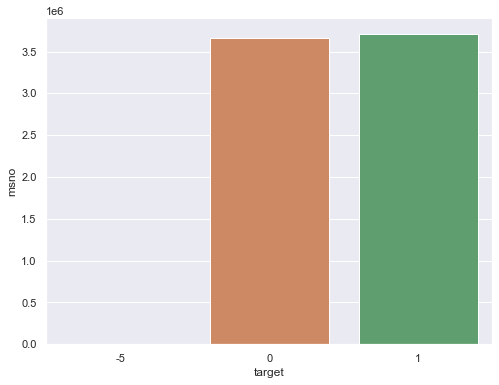

In [28]:
data = train_merged.groupby('target').aggregate({'msno':'count'}).reset_index()
a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='target', y='msno', data=data)

<AxesSubplot:xlabel='source_system_tab', ylabel='msno'>

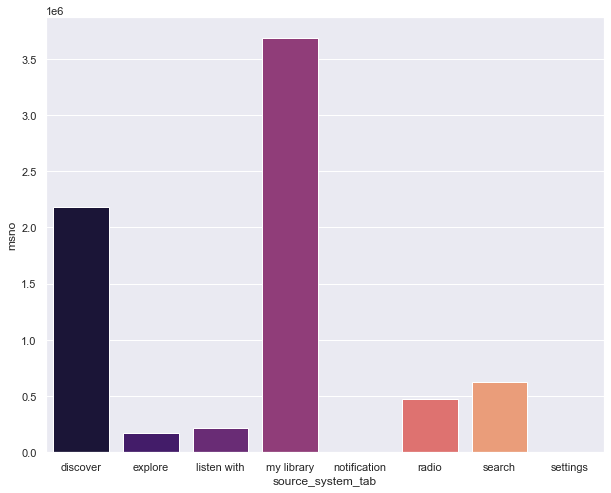

In [29]:
mpl.rcParams['font.size'] = 40.0
plt.figure(figsize = (10, 8)) 
data=train_merged.groupby('source_system_tab').aggregate({'msno':'count'}).reset_index()
sns.barplot(x='source_system_tab',y='msno',data=data, palette = 'magma')

[Text(0, 0, 'Album more'),
 Text(1, 0, 'Artist more'),
 Text(2, 0, 'Concert'),
 Text(3, 0, 'Discover Chart'),
 Text(4, 0, 'Discover Feature'),
 Text(5, 0, 'Discover Genre'),
 Text(6, 0, 'Discover New'),
 Text(7, 0, 'Explore'),
 Text(8, 0, 'Local playlist more'),
 Text(9, 0, 'My library'),
 Text(10, 0, 'My library_Search'),
 Text(11, 0, 'Online playlist more'),
 Text(12, 0, 'Others profile more'),
 Text(13, 0, 'Payment'),
 Text(14, 0, 'Radio'),
 Text(15, 0, 'Search'),
 Text(16, 0, 'Search Home'),
 Text(17, 0, 'Search Trends'),
 Text(18, 0, 'Self profile more'),
 Text(19, 0, 'Unknown')]

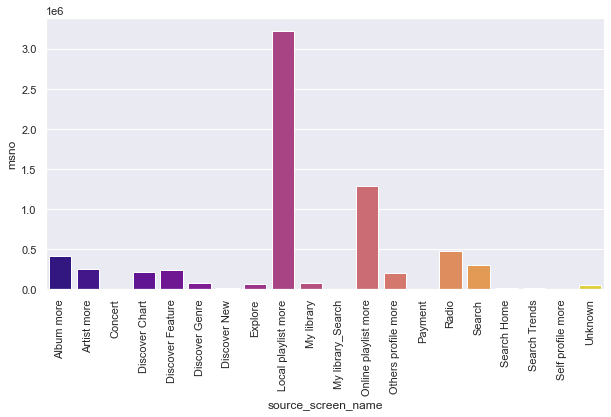

In [30]:
data = train_merged.groupby('source_screen_name').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='source_screen_name', y='msno', data=data, palette = 'plasma')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, 'album'),
 Text(1, 0, 'artist'),
 Text(2, 0, 'listen-with'),
 Text(3, 0, 'local-library'),
 Text(4, 0, 'local-playlist'),
 Text(5, 0, 'my-daily-playlist'),
 Text(6, 0, 'online-playlist'),
 Text(7, 0, 'radio'),
 Text(8, 0, 'song'),
 Text(9, 0, 'song-based-playlist'),
 Text(10, 0, 'top-hits-for-artist'),
 Text(11, 0, 'topic-article-playlist')]

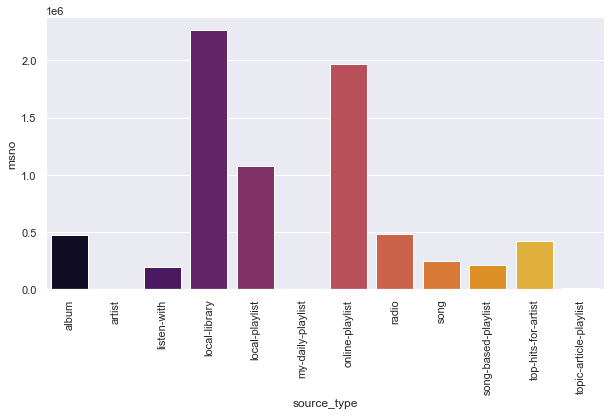

In [31]:
data = train_merged.groupby('source_type').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='source_type', y='msno', data=data, palette = 'inferno')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '-5'),
 Text(1, 0, '-1'),
 Text(2, 0, '3'),
 Text(3, 0, '10'),
 Text(4, 0, '17'),
 Text(5, 0, '24'),
 Text(6, 0, '31'),
 Text(7, 0, '38'),
 Text(8, 0, '45'),
 Text(9, 0, '52'),
 Text(10, 0, '59')]

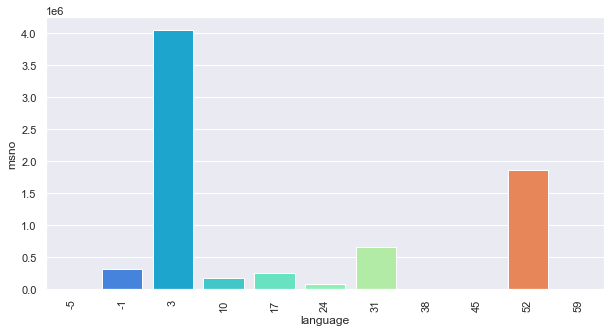

In [32]:
data = train_merged.groupby('language').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='language', y='msno', data=data, palette = 'rainbow')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '-5'),
 Text(1, 0, '3'),
 Text(2, 0, '4'),
 Text(3, 0, '7'),
 Text(4, 0, '9'),
 Text(5, 0, '13')]

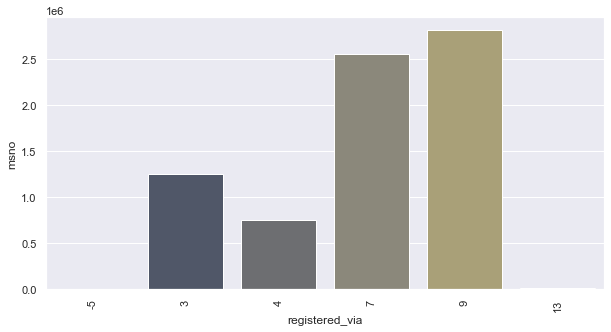

In [33]:
data = train_merged.groupby('registered_via').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='registered_via', y='msno', data=data, palette = 'cividis')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Most users 7 and 9 ways to get registered

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'song_length', 'genre_ids',
       'artist_name', 'composer', 'lyricist', 'language'],
      dtype='object')


[Text(0, 0, '-5'),
 Text(1, 0, '1'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5'),
 Text(5, 0, '6'),
 Text(6, 0, '7'),
 Text(7, 0, '8'),
 Text(8, 0, '9'),
 Text(9, 0, '10'),
 Text(10, 0, '11'),
 Text(11, 0, '12'),
 Text(12, 0, '13'),
 Text(13, 0, '14'),
 Text(14, 0, '15'),
 Text(15, 0, '16'),
 Text(16, 0, '17'),
 Text(17, 0, '18'),
 Text(18, 0, '19'),
 Text(19, 0, '20'),
 Text(20, 0, '21'),
 Text(21, 0, '22')]

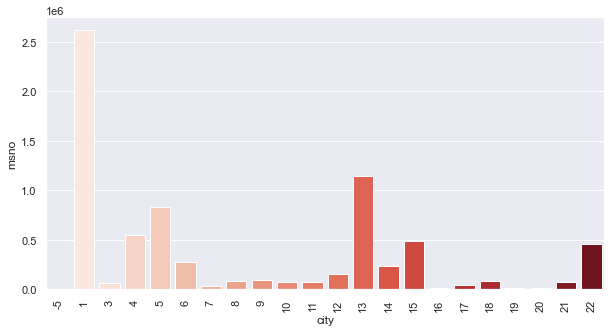

In [34]:
print(train_merged.columns)
data = train_merged.groupby('city').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='city', y='msno', data=data, palette = 'Reds')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### No of users in 1,5,13 are containing maximum values

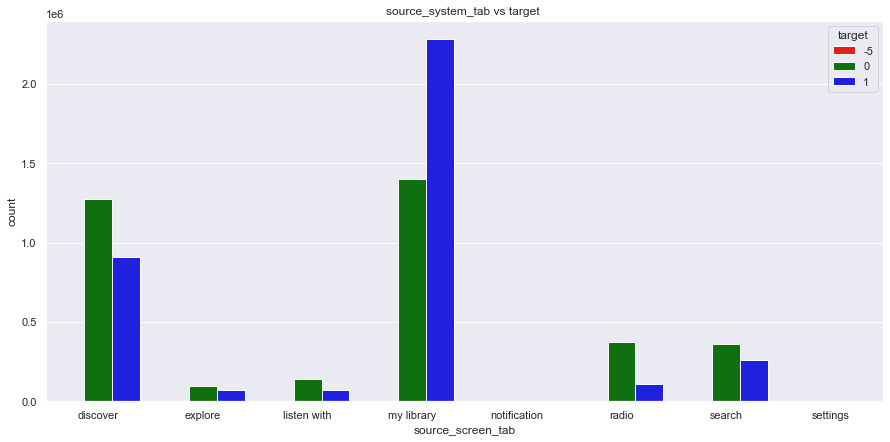

In [35]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="source_system_tab",data=train_merged,palette=['red','green','blue'],hue="target")
plt.xlabel("source_screen_tab")
plt.ylabel("count")
plt.title("source_system_tab vs target ")
plt.show()

### New users are coming from discover and my llibrary and old ones are from my library

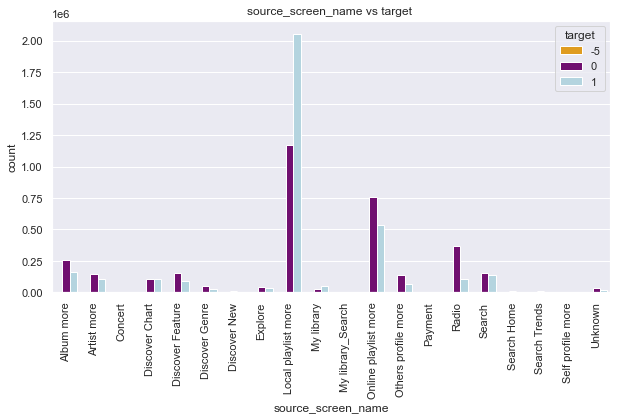

In [36]:
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="source_screen_name",data=train_merged,palette=['orange','purple','lightblue'],hue="target")
plt.xlabel("source_screen_name")
plt.ylabel("count")
plt.title("source_screen_name vs target ")
plt.xticks(rotation='90')
plt.show()

### Local playlist among new user and old one more most common way to get back their songs

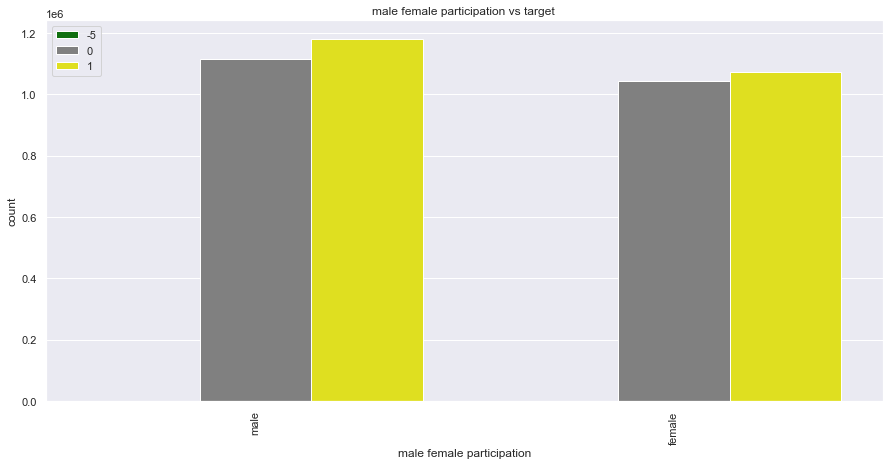

In [37]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="gender",data=train_merged,palette=['green','grey','yellow'],hue="target")
plt.xlabel("male female participation")
plt.ylabel("count")
plt.title("male female participation vs target ")
plt.xticks(rotation='90')
plt.legend(loc='upper left')
plt.show()

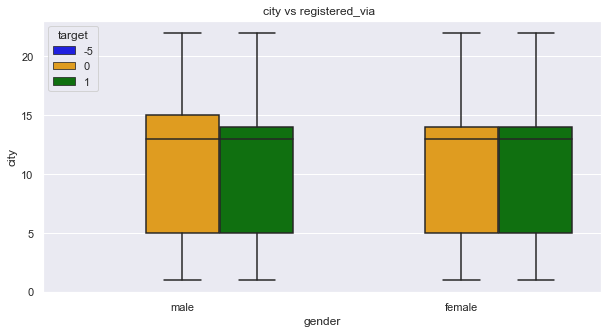

In [38]:
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.boxplot(x="gender",y="city",data=train_merged,palette=['blue','orange','green'],hue="target")
plt.xlabel("gender")
plt.ylabel("city")
plt.title("city vs registered_via  ")
plt.show()

In [39]:
print('Shape of train is :',train.shape)
print('Shape of test is :',test.shape)
print('Shape of Song Extra Info is :',sei.shape)
print('Shape of Members is :',members.shape)
print('Shape of Songs is :',songs.shape)

Shape of train is : (7377418, 6)
Shape of test is : (2556790, 6)
Shape of Song Extra Info is : (2295971, 3)
Shape of Members is : (34403, 7)
Shape of Songs is : (2296320, 7)


In [40]:
def get_codes(isrc):
    if pd.isnull(isrc):
        return np.nan
    else:
        if int(str(isrc)[5:7]) > 17:
            temp =  1900+int(str(isrc)[5:7])
        else:
            temp = 2000+int(isrc[5:7])
        return temp

In [41]:
sei['year'] = sei['isrc'].apply(lambda x: get_codes(x))
sei.sample(10)

,song_id,name,isrc,year
359133,QjC7qeN+8F+XIRa2+yBICgZ3SGtdIdLSuRE7qIBOrk8=,風兒！請捎個信(Take My Mind For My Love),TWC810305012,2003.0
1749608,foICuvt+oRrfcpRWgwbb0emEo5XkZRCvo/tGoL9Jrc0=,Wo willst du hin? - Radio Edit,DES810100017,2001.0
1434436,eFC0z7AChzv4+SEJU2UrI7BCH+bahFc0mS63yNALduw=,Fantasia,DEF078002720,1980.0
2218929,4W72i/389ehJt8U3di5RxMN7L9pYGBl9pQeK0ySEIwE=,Blueberry Hill,IT0411600989,2016.0
917156,HI4Ta0HVNjB/Fe4VIJCD1qaRR8PZ9uDHoR+wqxqb2d0=,When the Girls Talk Boys,AUXN21528958,2015.0
355947,1f+/pwgWLlDAlP+z778bT1Lx7rSgOHBrH7IobzrMxR4=,Hikari no saki e,JPKI01517070,2015.0
618969,uYIVo1vjUKKLXS0YFVuO1jHatqnnCavTkyThLFZPKxc=,Feels Right,GBGNZ1600243,2016.0
356854,2+QPviG/013FfZej7rRYezbduyH2Hm+N6uO3jpNNA2w=,2 Kinds of Men,PT7CK1400015,2014.0
545788,Dn3NNAzrAm9PBFwOypM6dlgZ9GJerSKPeOBeN56AfYU=,"Toujours Gai (From ""Shinbone Alley"")",USRC15706954,1957.0
227378,IoTSSmwZ6KUBdklh6ZH9xPtL1khEF+U+/TnolmPfbZk=,轉啊轉,TWT271200008,2012.0


In [42]:
members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)
members['registration_year'] = members['registration_init_time'].dt.year
members['expiration_year'] = members['expiration_date'].dt.year
members.drop(columns = ['registration_init_time' , 'expiration_date'] , inplace = True)
members.head()

,msno,city,bd,gender,registered_via,membership_days,registration_year,expiration_year
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2223,2011,2017
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,725,2015,2017
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,457,2016,2017
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,1,2015,2015
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,138,2017,2017


In [43]:
# Extending columns
# merging the database
train = train.merge(songs , on='song_id' , how='left')
train = train.merge(members , on = 'msno' , how='left')
train = train.merge(sei , on = 'song_id' , how='left')
test  = test.merge(songs , on='song_id' , how='left')
test = test.merge(members , on = 'msno' , how = 'left')
test =  test.merge(sei , on = 'song_id' , how = 'left')
del sei ,members , songs
gc.collect()

11168

In [44]:
print(train['song_length'].isnull().value_counts()/train.shape[0])
train['song_length'].fillna(train['song_length'].mean() , inplace = True)
train['song_length'] = train['song_length'].astype(np.uint32)
print(train['language'].isnull().value_counts()/train.shape[0])
train['language'].fillna(train['language'].mode().values[0] , inplace= True)
train['language'] = train['language'].astype(np.int8)
test['song_length'].fillna(test['song_length'].mean() , inplace = True)
test['song_length'] = test['song_length'].astype(np.uint32)
test['language'].fillna(test['language'].mode().values[0] , inplace= True)
test['language'] = test['language'].astype(np.int8)

False    0.999985
True     0.000015
Name: song_length, dtype: float64
False    0.99998
True     0.00002
Name: language, dtype: float64


In [45]:
def genre_count(genre):
    if genre == 'no_genre_id':
        return 0
    else :
        return genre.count('|') + 1
print(train['genre_ids'].isnull().value_counts()/train.shape[0])
train['genre_ids'].fillna('no_genre_id' , inplace= True)
train['genre_ids_count'] = train['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)
test['genre_ids'].fillna('no_genre_id' , inplace= True)
test['genre_ids_count'] = test['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)

False    0.983944
True     0.016056
Name: genre_ids, dtype: float64


In [46]:
def artist_count(art):
    if art=='no_artist_name':
        return 0
    else:
        return art.count('|')+art.count('/') + art.count('//') + art.count(';') + 1
train['artist_name'].isnull().value_counts()
train['artist_name'].fillna('no_artist_name' , inplace = True)
train['artist_count'] = train['artist_name'].apply(lambda x : artist_count(x)).astype(np.int8)
test['artist_name'].fillna('no_artist_name' , inplace = True)
test['artist_count'] = test['artist_name'].apply(lambda x : artist_count(x)).astype(np.int8)

In [47]:
def  count_composer(comp):
    if comp=='no_composer':
        return 0
    else:
        return comp.count('|')+comp.count('/') + comp.count('//') + comp.count(';') + 1
def  count_lyricist(lyr):
    if lyr=='no_lyricist':
        return 0
    else:
        return lyr.count('|')+lyr.count('/') + lyr.count('//') + lyr.count(';') + 1

In [48]:
train['composer'].fillna('no_composer',inplace=True)
train['composer_count'] = train['composer'].apply(lambda x: count_composer(x)).astype(np.int8)
train['lyricist'].fillna('no_lyricist',inplace=True)
train['lyricist_count'] = train['lyricist'].apply(lambda x: count_lyricist(x)).astype(np.int8)
test['composer'].fillna('no_composer',inplace=True)
test['composer_count'] = test['composer'].apply(lambda x: count_composer(x)).astype(np.int8)
test['lyricist'].fillna('no_lyricist',inplace=True)
test['lyricist_count'] = test['lyricist'].apply(lambda x: count_lyricist(x)).astype(np.int8)

In [49]:
dict_count_song_played_train = {k: v for k, v in train['song_id'].value_counts().iteritems()}
dict_count_song_played_test = {k: v for k, v in test['song_id'].value_counts().iteritems()}
def return_number_played(x):
    try:
        return dict_count_song_played_train[x]
    except KeyError:
        try:
            return dict_count_song_played_test[x]
        except KeyError:
            return 0
train['number_of_time_played'] = train['song_id'].apply(lambda x: return_number_played(x))
test['number_of_time_played'] = test['song_id'].apply(lambda x: return_number_played(x))

In [50]:
dict_user_activity = {k:v for k,v in pd.concat([train['msno'] , test['msno']] , axis = 0).value_counts().iteritems()}
def return_user_activity(x):
    try:
        return dict_user_activity[x]
    except KeyError:
        return 0
train['user_activity_msno'] = train['msno'].apply(lambda x: return_user_activity(x))
test['user_activity_msno'] = test['msno'].apply(lambda x: return_user_activity(x))

In [51]:
train_col = list(train.columns)
test_col = list(test.columns)
for f in test_col :
    if f not in train_col:
        print('ERROR !!!  Column from Test not found in train is ->' , f)
label_encoding = ['source_system_tab', 'source_screen_name',
       'source_type','gender']
drop = ['msno', 'song_id' , 'isrc','artist_name',
       'composer', 'lyricist','name','genre_ids']
min_max_scaling = ['number_of_time_played', 'user_activity_msno','membership_days', 'song_length']

ERROR !!!  Column from Test not found in train is -> id


In [52]:
for f in label_encoding:
    lb = LabelEncoder()
    lb.fit(list(train[f].values) + list(test[f].values))
    train[f] = lb.transform(list(train[f].values))
    test[f] = lb.transform(list(test[f].values))
for f in min_max_scaling:
    ms = MinMaxScaler()
    train[f] = ms.fit_transform(train[[f]])
    test[f] = ms.transform(test[[f]])
# train.drop(columns = drop , inplace = True)
# test.drop(columns=drop , inplace = True)

In [53]:
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

In [54]:
train.sample(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,expiration_year,name,isrc,year,genre_ids_count,artist_count,composer_count,lyricist_count,number_of_time_played,user_activity_msno
1751117,tLooo5MAY0aeck2TysonPpApJUeOh0ifgn6K8DZixfg=,Evt5gdtaDG2+3dq8JB5+8qKWP3QU9pkyFNCd8a1z1zk=,3,8,4,1,0.019956,458,Dr. 蘇盈之 (Soo Wincci),楊鎮邦,...,2017,分手的慶功,TWB671606001,2016.0,1,1,1,1,0.109648,0.236285
1349644,x7aPjz7BeW8mZgFOUppXx3z9dguB9qmSmBw2VhSW8L4=,OAIBxekYEb8alz8SDpozofgTf5qL3nozyuHJPvjr9QU=,3,8,3,1,0.025130,458,林志炫 (Terry Lin),Yao-Chuan Chen,...,2017,單身情歌 (Dan Shen Qing Ge),TWB659900401,1999.0,1,1,1,1,0.058331,0.184721
2453307,yeGLoZOH/vrhGnBWP98Vmxt39sVwB0G6RfqgluJ0q28=,M7EG3pgB4tkiigtJRUAiMaz3cx86t4+/AJfwGCKBSG0=,3,8,3,0,0.022656,458,梁靜茹 (Fish Leong),Lan Yin Wang,...,2017,小愛情,TWUM71200045,2012.0,1,1,1,0,0.010521,0.132142
4525698,CpZ0PzYenF2360pAz4pse2su7JelPObkQFfcefUekKU=,Vhkq4kH5xXAacZTOwvZJcP6Sj8agVO4w8AAI1DOx5v4=,3,8,4,0,0.020268,465,蘇運瑩,蘇運瑩,...,2017,冥明,TWO131501601,2015.0,1,1,1,1,0.015960,0.126314
2008306,IhiE9zqVslloQQzuKlSXpGDh2thbEVj1DSekFNKEI1M=,wjPEOKuPbryuv60uY9PgePrLDQTir5xJYWx/wwW+ri4=,1,11,7,0,0.022185,465,aMEI (張惠妹),陶喆/范中芬,...,2017,愛 什麼稀罕,TWB519906303,1999.0,1,1,2,2,0.024979,0.019131
4646286,VPxFUguhhMCmZfvdky4d4BEv+IAvMDgL6OXZCmeYrQA=,KICqPvL/JRg5/jPfRliXuNR2VJrpQ/u1zAMN6+rRRAU=,7,1,11,0,0.020422,465,曹格 (Gary Chaw),曹格,...,2017,妳是我的寶貝,TWA450689505,2006.0,1,1,1,1,0.015173,0.021918
47984,hDrZP3wE9UhGIBt/a4oMoxN+YmU4sL/ushvPktc5rN4=,hGBHl5fRcDcD23+iOVuXpZ/YJL5WJfDxY426obV+dxs=,0,0,0,1,0.025006,1152|947,心靈SPA音樂系列,no_composer,...,2017,清淺一灣,TWC810704008,2007.0,2,1,0,0,0.000573,0.180033
5688065,/A6sqt60VJBGT59/JZXPvBXKY9uW/5GofKHv8f9hKco=,B4zTMZ/an9RmxBJHxlP07ByYW45ycQGtqu6G89GNFM0=,3,8,4,1,0.023774,458,周杰倫 (Jay Chou),周杰倫,...,2017,星晴,TWK970000103,2000.0,1,1,1,1,0.093330,0.044216
3731576,Ot1y4vQhA6UqcqwgsFQ3tZrSG9XrlzHv9Vb58rrWcSE=,7gT49YDGdjPnN6CvAmbBLxErSs3fchta8+kCHWfuquM=,0,11,7,1,0.014972,1259,Rich Chigga,no_composer,...,2017,Seventeen,USUYG1124135,2011.0,1,1,0,0,0.065918,0.059546
6494462,zBDf8RGVk0AqZgu50rQQhr6+2YB3w3qXl+6dXvWTx58=,woOlWc20G3D4jgygA0QzsCVcAkZDNjFH6pMfCIg+y7M=,7,11,7,1,0.027260,465,周杰倫 (Jay Chou),周杰倫,...,2017,七里香,TWK970400702,2004.0,1,1,1,1,0.130976,0.245914


In [55]:
X_train = train.drop(columns = ['target'] , axis = 1)
Y_train = train['target'].values
X_test = test.drop(columns = ['id'] , axis = 1)
ids = test['id'].values
del train , test
gc.collect()
train_set = lgb.Dataset(X_train , Y_train)

In [56]:
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'learning_rate': 0.3 ,
        'verbose': 0,
        'num_leaves': 108,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10,
        'num_rounds': 200,
        'metric' : 'auc'
    }

%time model_f1 = lgb.train(params, train_set=train_set,  valid_sets=train_set, verbose_eval=5)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.450254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[5]	training's auc: 0.736167
[10]	training's auc: 0.748005
[15]	training's auc: 0.754421
[20]	training's auc: 0.759233
[25]	training's auc: 0.762544
[30]	training's auc: 0.765713
[35]	training's auc: 0.768136
[40]	training's auc: 0.771355
[45]	training's auc: 0.773379
[50]	training's auc: 0.775447
[55]	training's auc: 0.777483
[60]	training's auc: 0.779126
[65]	training's auc: 0.780748
[70]	training's auc: 0.782426
[75]	training's auc: 0.784057
[80]	training's auc: 0.785748
[85]	training's auc: 0.787138
[90]	training's auc: 0.78843
[95]	training's auc: 0.789651
[100]	training's auc: 0.790847
[105]	training's auc: 0.791955
[110]	training's auc: 0.792972
[115]	training's auc: 0.793971
[120]	training's auc: 0.794948
[125]	training's auc: 0.795891
[130]	training's auc: 0.798364
[135]	training's auc: 0.799259
[140]	training's au

In [57]:
pred_test = model_f1.predict(X_test)
print('Saving Predictions')
sub = pd.DataFrame()
sub['id'] = ids
sub['target'] = pred_test
sub.to_csv('1st_submission.csv' , index = False , float_format ='%.5f' )

Saving Predictions


In [58]:
sub.head()

,id,target
0,0,0.384199
1,1,0.310859
2,2,0.198129
3,3,0.119010
4,4,0.097116


### Thank You